# Laboratory practice 2 QCO

<h3 style="font-size: 20px"> Important notes: </h3>

- This .pynb file is ready for execution in a Google Colab (https://colab.research.google.com) environment. Just upload it and open it from a regular Colab session.

- In case you cannot attend the lab session or you do not manage to finish all exercises during the lab session, the answers of Lab 2 have to be sent by email to Juan Carlos Perez (jcperez@disca.upv.es). **Note that the deadline for sending the answers of Lab 2 is March 4.**

- Use the "print" menu option of the Google Colab environment to create a PDF file. Please name the file with your answers as “Lab2_student_name.pdf”.

- If you have any question about this lab, please send an e-mail to Juan Carlos Perez (jcperez@disca.upv.es)

In [ ]:
# ALWAYS RUN THIS CELL AFTER YOU LOAD (OR RELOAD) THE NOTEBOOK

# Generic cell for correct operation of QCO materials in Google Colab (jcperez@disca.upv.es):
!pip -qqq install qiskit[visualization]
import qiskit
%matplotlib inline
qiskit.__version__

# Not always necessary (jcperez@disca.upv.es):
!pip -qqq install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

# To fix a bug/version incompatibility in that file (jcperez@disca.upv.es):
!sed -ie 's/denominator/denominator()/g' /usr/local/lib/python3.8/dist-packages/qiskit/visualization/array.py

# To set graphical circuit drawing by default in qiskit (jcperez@disca.upv.es):
!mkdir ${HOME}/.qiskit 2>/dev/null
!printf "[default]\ncircuit_drawer = mpl\n" > ${HOME}/.qiskit/settings.conf

## Part 1. Basic Qiskit Syntax

In [ ]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np

### Quantum circuits

The object at the heart of Qiskit is the quantum circuit. Here's how we create one, which we will call `qc`

In [ ]:
from qiskit import QuantumCircuit
qc = QuantumCircuit()

This circuit is currently completely empty, with no qubits and no outputs.

### Quantum registers

To make the circuit less trivial, we need to define a register of qubits. This is done using a `QuantumRegister` object. For example, let's define a register consisting of two qubits and call it `qr`.

In [ ]:
from qiskit import QuantumRegister
qr = QuantumRegister(2,'a')

Giving it a label like `'a'` is optional.

Now we can add it to the circuit using the `add_register` method, and see that it has been added by checking the `qregs` variable of the circuit object. This guide uses [Jupyter Notebooks](https://jupyter.org/). In Jupyter Notebooks, the output of the last line of a cell is displayed below the cell:

In [ ]:
qc.add_register( qr )

qc.qregs

Now our circuit has some qubits, we can use another attribute of the circuit to see what it looks like: `draw()` .

In [ ]:
qc.draw()

Our qubits are ready to begin their journey, but are currently just sitting there in state $\left|0\right\rangle$.

#### Applying Gates

To make something happen, we need to add gates. For example, let's try out `h()`.

In [ ]:
qc.h()

Here we got an error, because we didn't tell the operation which qubit it should act on. The two qubits in our register `qr` can be individually addressed as `qr[0]` and `qr[1]`.

In [ ]:
qc.h(qr[0])

Ignore the output in the above. When the last line of a cell has no `=`, Jupyter notebooks like to print out what is there. In this case, it's telling us that there is a Hadamard as defined by Qiskit. To suppress this output, we could use a `;`.

We can also add a controlled-NOT using `cx`. This requires two arguments: control qubit, and then target qubit.

In [ ]:
qc.cx(qr[0], qr[1])

Now our circuit has more to show

In [ ]:
qc.draw()

### Aer simulator

We are now at the stage that we can actually look at an output from the circuit. Specifically, we will use the 'aer simulator' to see what is happening to the state vector of the two qubits.

To get this simulator ready to go, we use the following line.

In [ ]:
from qiskit import Aer
sv_sim = Aer.get_backend('aer_simulator')

In Qiskit, we use *backend* to refer to the things on which quantum programs actually run (simulators or real quantum devices). To set up a job for a backend, we need to set up the corresponding backend object.

The simulator we want is defined in the part of qiskit known as `Aer`. By giving the name of the simulator we want to the `get_backend()` method of Aer, we get the backend object we need. In this case, the name is `'aer_simulator'`.

A list of all possible simulators in Aer can be found using

In [ ]:
for backend in Aer.backends():
    print(backend)

All of these simulators are 'local', meaning that they run on the machine on which Qiskit is installed. Using them on your own machine can be done without signing up to the IBMQ user agreement.

We then use the `.run()` method of the backend we want to use (in this case a simulator) to run the experiment. This is where the quantum computations happen!

In [ ]:
qc.save_statevector()
job = sv_sim.run(qc)

This creates an object that handles the job, which here has been called `job`. All we need from this is to extract the result. Specifically, we want the state vector.

In [ ]:
ket = job.result().get_statevector()
for amplitude in ket.data:
    print(amplitude)

This is the vector for a Bell state $\left( \left|00\right\rangle + \left|11\right\rangle \right)/\sqrt{2}$, which is what we'd expect given the circuit.

While we have a nicely defined state vector, we can show another feature of Qiskit: it is possible to initialize a circuit with an arbitrary pure state.

In [ ]:
new_qc = QuantumCircuit(qr)

new_qc.initialize(ket, qr)

### Classical registers and the Aer simulator

In the above simulation, we got out a statevector. That's not what we'd get from a real quantum computer. For that we need measurement. And to handle measurement we need to define where the results will go. This is done with a `ClassicalRegister`. Let's define a two bit classical register, in order to measure both of our two qubits.

In [ ]:
from qiskit import ClassicalRegister
cr = ClassicalRegister(2,'creg')

qc.add_register(cr)

Now we can use the `measure` method of the quantum circuit. This requires two arguments: the qubit being measured, and the bit where the result is written.

Let's measure both qubits, and write their results in different bits.

In [ ]:
qc.measure(qr[0],cr[0])
qc.measure(qr[1],cr[1])

qc.draw()

Now we can run this on a local simulator whose effect is to emulate a real quantum device. For this we need to add another input to the `run` method, `shots`, which determines how many times we run the circuit to take statistics. If you don't provide any `shots` value, you get the default of 1024.

In [ ]:
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(qc, shots=8192)

The result is essentially a histogram in the form of a Python dictionary. We can use `print` to display this for us.

In [ ]:
hist = job.result().get_counts()
print(hist)

We can even get Qiskit to plot it as a histogram.

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(hist)

For compatible backends we can also ask for and get the ordered list of results.

In [ ]:
job = aer_sim.run(qc, shots=10, memory=True)
samples = job.result().get_memory()
print(samples)

Note that the bits are labelled from right to left. So `cr[0]` is the one to the furthest right, and so on. As an example of this, here's an 8 qubit circuit with a Pauli $X$ on only the qubit numbered `7`, which has its output stored to the bit numbered `7`.

In [ ]:
qubit = QuantumRegister(8)
bit = ClassicalRegister(8)
qc_2 = QuantumCircuit(qubit,bit)

qc_2.x(qubit[7])
qc_2.measure(qubit,bit) # this is a way to do all the qc.measure(qr8[j],cr8[j]) at once

aer_sim.run(qc_2, shots=8192).result().get_counts()

The `1` appears at the left.
This numbering reflects the role of the bits when they represent an integer.



$$ b_{n-1} ~ b_{n-2} ~ \ldots ~ b_1 ~ b_0 = \sum_j ~ b_j ~ 2^j $$



So the string we get in our result is the binary for $2^7$ because it has a `1` for the bit numbered `7`.


Now, draw the circuit to understand better this result.


### Simplified notation

Multiple quantum and classical registers can be added to a circuit. However, if we need no more than one of each, we can use a simplified notation.

For example, consider the following.

In [ ]:
qc = QuantumCircuit(3)

The single argument to `QuantumCircuit` is interpreted as the number of qubits we want. So this circuit is one that has a single quantum register consisting of three qubits, and no classical register.

When adding gates, we can then refer to the three qubits simply by their index: 0, 1 or 2. For example, here's a Hadamard on qubit 1.

In [ ]:
qc.h(1)

qc.draw()

To define a circuit with both quantum and classical registers, we can supply two arguments to `QuantumCircuit`. The first will be interpreted as the number of qubits, and the second will be the number of bits. For example, here's a two qubit circuit for which we'll take a single bit of output.

In [ ]:
qc = QuantumCircuit(2,1)

To see this in action, here is a simple circuit. Note that, when making a measurement, we also refer to the bits in the classical register by index.

In [ ]:
qc.h(0)
qc.cx(0,1)
qc.measure(1,0)

qc.draw()

### Creating custom gates

As we've seen, it is possible to combine different circuits to make bigger ones. We can also use a more sophisticated version of this to make custom gates. For example, here is a circuit that implements a `cx` between qubits 0 and 2, using qubit 1 to mediate the process.

In [ ]:
sub_circuit = QuantumCircuit(3, name='toggle_cx')
sub_circuit.cx(0,1)
sub_circuit.cx(1,2)
sub_circuit.cx(0,1)
sub_circuit.cx(1,2)

sub_circuit.draw()

We can now turn this into a gate

In [ ]:
toggle_cx = sub_circuit.to_instruction()

and then insert it into other circuits using any set of qubits we choose

In [ ]:
qr = QuantumRegister(4)
new_qc = QuantumCircuit(qr)

new_qc.append(toggle_cx, [qr[1],qr[2],qr[3]])

new_qc.draw()

### Accessing on real quantum hardware

Backend objects can also be set up using the `IBMQ` package. The use of these requires us to [sign with an IBMQ account](https://quantum-computing.ibm.com/lab/files/qiskit-tutorials/qiskit/circuits/1_getting_started_with_qiskit). When you have your account, you will find your API token [here](https://quantum-computing.ibm.com/account) and copy-paste it in the next cell:

In [ ]:
from qiskit import IBMQ
IBMQ.enable_account(token="YOUR API TOKEN HERE")

Now let's see what additional backends we have available.

In [ ]:
provider = IBMQ.get_provider(hub='ibm-q')
for backend in provider.backends():
    print(backend)

Here there is one simulator, but the rest are prototype quantum devices.

We can see what they are up to with the `status()` method.

In [ ]:
for backend in provider.backends():
    print(backend.status().to_dict())

Let's get the backend object for one of these devices.

In [ ]:
real_device = provider.get_backend('ibm_nairobi')

We can use this to run a job on the device in exactly the same way as for the emulator.

We can also extract some of its properties.

In [ ]:
properties = real_device.properties()
real_device.configuration().coupling_map

From this we can construct a noise model to mimic the noise on the device (we will discuss noise models further later in the textbook).

In [ ]:
from qiskit.providers.fake_provider import FakeAthens
athens = FakeAthens()

And then run the job on the emulator, with it reproducing all these features of the real device. Here's an example with a circuit that should output `'11111'` in the noiseless case.

In [ ]:
qc = QuantumCircuit(5)
qc.x(0)
for q in range(4):
    qc.cx(0,q+1)
qc.measure_all()
qc.draw()

In [ ]:
from qiskit.visualization import plot_gate_map
plot_gate_map(athens)

In [ ]:
from qiskit import transpile
t_qc = transpile(qc, athens)
t_qc.draw()

In [ ]:
counts = athens.run(t_qc).result().get_counts()
plot_histogram(counts)

Please, simulate with the "aer simulator" and plot the result of the noiseless version of the circuit.


Now the very basics have been covered, let's learn more about what qubits and quantum circuits are all about.



<h2 style="font-size:24px;">Part 2: Classical logic gates with quantum circuits</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Create quantum circuit functions that can compute the XOR, AND, NAND and OR gates using the NOT gate (expressed as x in Qiskit), the CNOT gate (expressed as cx in Qiskit) and the Toffoli gate (expressed as ccx in Qiskit) .</p>
</div>

An implementation of the `NOT` gate is provided as an example.

In [ ]:
def NOT(inp):
    """An NOT gate.
    
    Parameters:
        inp (str): Input, encoded in qubit 0.
        
    Returns:
        QuantumCircuit: Output NOT circuit.
        str: Output value measured from qubit 0.
    """

    qc = QuantumCircuit(1, 1) # A quantum circuit with a single qubit and a single classical bit
    qc.reset(0)
    
    # We encode '0' as the qubit state |0⟩, and '1' as |1⟩
    # Since the qubit is initially |0⟩, we don't need to do anything for an input of '0'
    # For an input of '1', we do an x to rotate the |0⟩ to |1⟩
    if inp=='1':
        qc.x(0)
        
    # barrier between input state and gate operation 
    qc.barrier()
    
    # Now we've encoded the input, we can do a NOT on it using x
    qc.x(0)
    
    #barrier between gate operation and measurement
    qc.barrier()
    
    # Finally, we extract the |0⟩/|1⟩ output of the qubit and encode it in the bit c[0]
    qc.measure(0,0)
    qc.draw('mpl')
    
    # We'll run the program on a simulator
    backend = Aer.get_backend('qasm_simulator')
    # Since the output will be deterministic, we can use just a single shot to get it
    job = execute(qc, backend, shots=1, memory=True)
    output = job.result().get_memory()[0]
    
    return qc, output

In [ ]:
## Test the function
for inp in ['0', '1']:
    qc, out = NOT(inp)
    print('NOT with input',inp,'gives output',out)
    display(qc.draw())
    print('\n')

<h3 style="font-size: 20px">&#128211; XOR gate</h3>

Takes two binary strings as input and gives one as output.

The output is '0' when the inputs are equal and  '1' otherwise.

In [ ]:
def XOR(inp1,inp2):
    """An XOR gate.
    
    Parameters:
        inpt1 (str): Input 1, encoded in qubit 0.
        inpt2 (str): Input 2, encoded in qubit 1.
        
    Returns:
        QuantumCircuit: Output XOR circuit.
        str: Output value measured from qubit 1.
    """
  
    qc = QuantumCircuit(2, 1) 
    qc.reset(range(2))
    
    if inp1=='1':
        qc.x(0)
    if inp2=='1':
        qc.x(1)
    
    # barrier between input state and gate operation 
    qc.barrier()
    
    # this is where your program for quantum XOR gate goes
    
    
    
    
    
    
    
    
    # barrier between input state and gate operation 
    qc.barrier()
    
    qc.measure(1,0) # output from qubit 1 is measured
  
    #We'll run the program on a simulator
    backend = Aer.get_backend('qasm_simulator')
    #Since the output will be deterministic, we can use just a single shot to get it
    job = execute(qc, backend, shots=1, memory=True)
    output = job.result().get_memory()[0]
  
    return qc, output

In [ ]:
## Test the function
for inp1 in ['0', '1']:
    for inp2 in ['0', '1']:
        qc, output = XOR(inp1, inp2)
        print('XOR with inputs',inp1,inp2,'gives output',output)
        display(qc.draw())
        print('\n')

<h3 style="font-size: 20px">&#128211; AND gate</h3>

Takes two binary strings as input and gives one as output.

The output is `'1'` only when both the inputs are `'1'`.

In [ ]:
def AND(inp1,inp2):
    """An AND gate.
    
    Parameters:
        inpt1 (str): Input 1, encoded in qubit 0.
        inpt2 (str): Input 2, encoded in qubit 1.
        
    Returns:
        QuantumCircuit: Output XOR circuit.
        str: Output value measured from qubit 2.
    """
    qc = QuantumCircuit(3, 1) 
    qc.reset(range(2))
  
    if inp1=='1':
        qc.x(0)
    if inp2=='1':
        qc.x(1)
        
    qc.barrier()

    # this is where your program for quantum AND gate goes

    
    
    
    
    

    qc.barrier()
    qc.measure(2, 0) # output from qubit 2 is measured
  
    # We'll run the program on a simulator
    backend = Aer.get_backend('qasm_simulator')
    # Since the output will be deterministic, we can use just a single shot to get it
    job = execute(qc, backend, shots=1, memory=True)
    output = job.result().get_memory()[0]
  
    return qc, output

In [ ]:
## Test the function
for inp1 in ['0', '1']:
    for inp2 in ['0', '1']:
        qc, output = AND(inp1, inp2)
        print('AND with inputs',inp1,inp2,'gives output',output)
        display(qc.draw())
        print('\n')

<h3 style="font-size: 20px">&#128211; NAND gate</h3>

Takes two binary strings as input and gives one as output.

The output is `'0'` only when both the inputs are `'1'`.

In [ ]:
def NAND(inp1,inp2):
    """An NAND gate.
    
    Parameters:
        inpt1 (str): Input 1, encoded in qubit 0.
        inpt2 (str): Input 2, encoded in qubit 1.
        
    Returns:
        QuantumCircuit: Output NAND circuit.
        str: Output value measured from qubit 2.
    """
    qc = QuantumCircuit(3, 1) 
    qc.reset(range(3))
    
    if inp1=='1':
        qc.x(0)
    if inp2=='1':
        qc.x(1)
    
    qc.barrier()
    
    # this is where your program for quantum NAND gate goes


    
    
    
    
    
    qc.barrier()
    qc.measure(2, 0) # output from qubit 2 is measured
  
    # We'll run the program on a simulator
    backend = Aer.get_backend('qasm_simulator')
    # Since the output will be deterministic, we can use just a single shot to get it
    job = execute(qc,backend,shots=1,memory=True)
    output = job.result().get_memory()[0]
  
    return qc, output

In [ ]:
## Test the function
for inp1 in ['0', '1']:
    for inp2 in ['0', '1']:
        qc, output = NAND(inp1, inp2)
        print('NAND with inputs',inp1,inp2,'gives output',output)
        display(qc.draw())
        print('\n')

<h3 style="font-size: 20px">&#128211; OR gate</h3>

Takes two binary strings as input and gives one as output.

The output is '1' if either input is '1'.

In [ ]:
def OR(inp1,inp2):
    """An OR gate.
    
    Parameters:
        inpt1 (str): Input 1, encoded in qubit 0.
        inpt2 (str): Input 2, encoded in qubit 1.
        
    Returns:
        QuantumCircuit: Output XOR circuit.
        str: Output value measured from qubit 2.
    """

    qc = QuantumCircuit(3, 1) 
    qc.reset(range(3))
    
    if inp1=='1':
        qc.x(0)
    if inp2=='1':
        qc.x(1)
    
    qc.barrier()
   
    # this is where your program for quantum OR gate goes


    
    
    
    
    
    qc.barrier()
    qc.measure(2, 0) # output from qubit 2 is measured
  
    # We'll run the program on a simulator
    backend = Aer.get_backend('qasm_simulator')
    # Since the output will be deterministic, we can use just a single shot to get it
    job = execute(qc,backend,shots=1,memory=True)
    output = job.result().get_memory()[0]
  
    return qc, output

In [ ]:
## Test the function
for inp1 in ['0', '1']:
    for inp2 in ['0', '1']:
        qc, output = OR(inp1, inp2)
        print('OR with inputs',inp1,inp2,'gives output',output)
        display(qc.draw())
        print('\n')

<h2 style="font-size:24px;">Part 3: From a digital circuit to a quantum circuit</h2>
<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Build a quantum circuit that is equivalent to a given digital circuit.</p>
</div>

In Part 1 you made `NOT`, `XOR`, `AND`, `NAND` and `OR` gates from quantum gates, and executed them on the simulator.  Here in Part 2 you will combine them to implement a quantum circuit that corresponds to a given digital (classical) circuit.  

<h3 style="font-size: 20px">&#128211; The digital circuit</h3>

Given the circuit shown below, derive the boolean expression for the output F and its thruth table.

**Tip:** Remember that a truth table consists of $2^n$ rows that are all possible input combinations, being $n$ the number of inputs, and $n +1$ columns, n for the inputs and one for the output (the most right column).



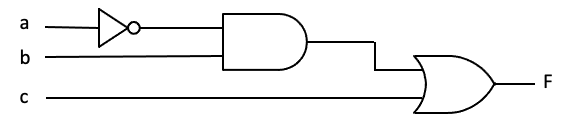




<h3 style="font-size: 20px">&#128211; The quantum circuit</h3>

Create the quantum circuit fucntion that implements the digital circuit shown above.

Verify that the output is correct for all possible input values ('000', '001', '010'...'111').

In [ ]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np

In [ ]:
def DQC(inp1,inp2,inp3):
    """A digital circuit.
    
    Parameters:
        inpt1 (str): Input 1, encoded in qubit 0.
        inpt2 (str): Input 2, encoded in qubit 1.
        inpt2 (str): Input 2, encoded in qubit 2.
    Returns:
        QuantumCircuit: Output digital circuit.
        str: Output value measured from qubit XX.
    """
   
    # here is where your program goes


    
    
    
    
    
    
  
    # We'll run the program on a simulator
    backend = Aer.get_backend('qasm_simulator')
    # Since the output will be deterministic, we can use just a single shot to get it
    job = execute(qc,backend,shots=1,memory=True)
    output = job.result().get_memory()[0]
  
    return qc, output

In [ ]:
## Test the function
 # here is where your program goes
